# Exploring UK's milk imports and exports

The United Nations Comtrade database provides data on global trade. Just like the example analyzed for the year 2015, the website will be used to analyse the UK's imports and exports of milk and cream in 2020. I will analyze:

- How much does the UK export and import and is the balance positive (more exports than imports)?
- Which are the main trading partners, i.e. from/to which countries does the UK import/export the most?
- Which are the regular customers, i.e. which countries buy milk from the UK every month?
- Which countries does the UK both import from and export to?

In [1]:
import warnings
warnings.simplefilter('ignore', FutureWarning)

from pandas import *
%matplotlib inline

## Getting and Preparing the data
Just like the example alrady done, the data is taken from here [United Nations Comtrade] (https://comtrade.un.org/data/) by selecting the following configuration:

- Type of Product: goods
- Frequency: monthly 
- Periods: All of 2020
- Reporter: United Kingdom
- Partners: all
- Flows: imports and exports
- HS (as reported) commodity codes: 0401 (Milk and cream, neither concentrated nor sweetened) and 0402 (Milk and cream, concentrated or sweetened)

Data was downloaded using the *Download CSV* button and the download file renamed appropriately.


In [2]:
LOCATION = 'uk_milk_import_export_2020.csv'

On reading in the data, the commodity code has to be read as a string, to not lose the leading zero.

In [4]:
milk_2020 = read_csv(LOCATION, dtype={'Commodity Code':str})
milk_2020.tail(2)

,Classification,Year,Period,Period Desc.,Aggregate Level,Is Leaf Code,Trade Flow Code,Trade Flow,Reporter Code,Reporter,...,Qty,Alt Qty Unit Code,Alt Qty Unit,Alt Qty,Netweight (kg),Gross weight (kg),Trade Value (US$),CIF Trade Value (US$),FOB Trade Value (US$),Flag
6622,HS,2020,202012,December 2020,0,0,1,Imports,826,United Kingdom,...,NaN,NaN,NaN,NaN,0.0,NaN,1101297379,NaN,NaN,0
6623,HS,2020,202012,December 2020,0,0,2,Exports,826,United Kingdom,...,NaN,NaN,NaN,NaN,0.0,NaN,1102726196,NaN,NaN,0


The data covers the the whole of 2020, that is from January to December. Some columns like the 'year' and 'reporter' columns are the same all through. The commodity code is transformed into a short but descriptive text and only the relevant columns are selected.

In [6]:
def milkCategory(code):
    if code == '0401': # neither concentrated nor sweetened
        return 'unprocessed'
    if code == '0402': # concentrated or sweetened
        return 'processed' 
    return 'unknown'

COMMODITY = 'Milk and cream'
milk_2020[COMMODITY] = milk_2020['Commodity Code'].apply(milkCategory)
MONTH = 'Period'
PARTNER = 'Partner'
FLOW = 'Trade Flow'
VALUE = 'Trade Value (US$)'
headings = [MONTH, PARTNER, FLOW, COMMODITY, VALUE]
milk_2020 = milk_2020[headings]
milk_2020.head()

,Period,Partner,Trade Flow,Milk and cream,Trade Value (US$)
0,202001,World,Imports,unprocessed,10334570
1,202001,World,Exports,unprocessed,27673353
2,202001,Austria,Imports,unprocessed,37107
3,202001,Austria,Exports,unprocessed,59
4,202001,Belgium,Imports,unprocessed,371607


The data contains the total imports and exports per month, under the 'World' partner. The rows containing the 'world' data are removed to keep the individual country data

In [7]:
milk_2020 = milk_2020[milk_2020[PARTNER] != 'World']
milk_2020.head()

,Period,Partner,Trade Flow,Milk and cream,Trade Value (US$)
2,202001,Austria,Imports,unprocessed,37107
3,202001,Austria,Exports,unprocessed,59
4,202001,Belgium,Imports,unprocessed,371607
5,202001,Belgium,Exports,unprocessed,668811
6,202001,Bermuda,Exports,unprocessed,1403


## Total Trade Flow

To answer the first question, 'how much does the UK export and import and is the balance positive (more exports than imports)?', the dataframe is split into two groups: exports from the UK and imports into the UK. The trade values within each group are summed up to get the total trading.

In [8]:
grouped = milk_2020.groupby([FLOW])
grouped[VALUE].aggregate(sum)

Trade Flow
Exports    400150592159
Imports    632202616662
Name: Trade Value (US$), dtype: int64

This shows a negative trade surplus of over 200 billion dollars. It means the UK imported milk more than they exported it in 2020

## Main Trade Partners

In order to answer the second question, 'Which are the main trading partners, i.e. from/to which countries does the UK import/export the most?',  I will split the dataframe by country and then each group aggregated for the total trade value. This is done separately for imports and exports. The result is sorted in descending order so that the main partners are at the top.

In [9]:
imports_2020 = milk_2020[milk_2020[FLOW] == 'Imports']
grouped = imports_2020.groupby([PARTNER])
print('The UK imports from', len(grouped), 'countries.')
print('The 5 biggest exporters to the UK are:')
totalImports_2020 = grouped[VALUE].aggregate(sum).sort_values(inplace=False,ascending=False)
totalImports_2020.head()

The UK imports from 228 countries.
The 5 biggest exporters to the UK are:


Partner
China                       75591642487
Germany                     73423453172
United States of America    58106290824
Netherlands                 45565261071
France                      29398922889
Name: Trade Value (US$), dtype: int64

The export values are plotted as a bar chart in order to make the differences between countries easier to see.

<AxesSubplot:ylabel='Partner'>

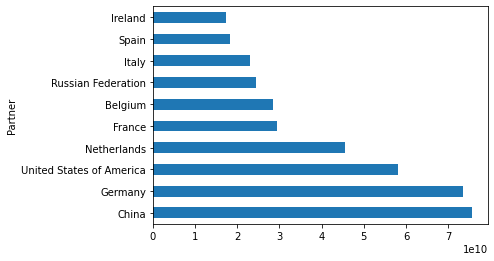

In [10]:
totalImports_2020.head(10).plot(kind='barh')

In [11]:
exports_2020 = milk_2020[milk_2020[FLOW] == 'Exports']
grouped = exports_2020.groupby([PARTNER])
print('The UK exports to', len(grouped), 'countries.')
print('The 5 biggest importers from the UK are:')
grouped[VALUE].aggregate(sum).sort_values(ascending=False,inplace=False).head()


The UK exports to 232 countries.
The 5 biggest importers from the UK are:


Partner
United States of America    57739501374
Germany                     41214629164
Ireland                     27709986722
Netherlands                 24884456368
France                      23561907566
Name: Trade Value (US$), dtype: int64

The UK imports most from China and exports most to the United States of America.

## Regular Importers

Given that there are two commodities, the third question, 'Which are the regular customers, i.e. which countries buy milk from the UK every month?', is meant in the sense that a regular customer imports both commodities every month. This means that if the exports dataframe is grouped by country, each group has exactly twenty four rows (two commodities bought each of the twelve months in the year). To see the countries, only the first month of one commodity has to be listed, as by definition it's the same countries every month and for the other commodity.

In [20]:
def customerBuysEveryMonth(group):
    return len(group) == 24

grouped = exports_2020.groupby([PARTNER])
regular = grouped.filter(customerBuysEveryMonth)
regular[(regular[MONTH] == 202001) & (regular[COMMODITY] == 'processed')]

,Period,Partner,Trade Flow,Milk and cream,Trade Value (US$)
738,202001,Congo,Exports,processed,621190
744,202001,Estonia,Exports,processed,56
802,202001,Egypt,Exports,processed,1109496


In [17]:
regular[VALUE].sum() / exports_2020[VALUE].sum()

0.019642335363274605

The regular customers are Egypt,Congo and Estonia

## Bi-directional Trade

To address the fourth question, 'Which countries does the UK both import from and export to?', a pivot table is used to list the total export and import value for each country.

In [21]:
countries_2020 = pivot_table(milk_2020, index=[PARTNER], columns=[FLOW], 
                        values=VALUE, aggfunc=sum)
countries_2020.head()

Trade Flow,Exports,Imports
Partner,,
Afghanistan,32147031.0,3715423.0
Albania,15719218.0,12654809.0
Algeria,330131687.0,605736015.0
American Samoa,248200.0,89010.0
Andorra,10422060.0,625782.0


Removing the rows with a missing value will result in only those countries with bi-directional trade flow with the UK.

In [23]:
countries_2020.dropna()

Trade Flow,Exports,Imports
Partner,,
Afghanistan,32147031.0,3.715423e+06
Albania,15719218.0,1.265481e+07
Algeria,330131687.0,6.057360e+08
American Samoa,248200.0,8.901000e+04
Andorra,10422060.0,6.257820e+05
...,...,...
Viet Nam,692588897.0,5.031619e+09
Wallis and Futuna Isds,27204.0,3.454000e+03
Yemen,34527681.0,6.406200e+05


## Conclusions
The milk and cream trade of the UK from January to December 2020 was analysed in terms of which countries the UK mostly depends on for income (exports) and goods (imports). Over the period, the UK had a negative trade surplus of over 200 billion US dollars.

China, United states of America and Germany are the main partners. The UK imports most from China and exports most to the United states of America.

The UK exported to 232 countries in 2020 and imported from 228 countries, the main ones (top five by trade value) being geographically close. China is the main exporter but not among the top five importers while the United States of America is the biggest importer and is the third higest exporter to the UK.

The UK is gets revenue from its regular customers, the 3 countries that buy all types of milk and cream every month. They contribute a significant amount to the total export value.

The UK has bi-directional trade (i.e. both exports and imports) with 227 countries.

